In [1]:
from __future__ import print_function
import os,sys
os.environ['DISABLE_MPI'] = "true"
from os.path import join as opj
from orphics import maps,io,cosmology,stats,pixcov
from pixell import enmap,curvedsky,utils,enplot
import numpy as np
import healpy as hp
from falafel import qe
import falafel.utils as futils
import matplotlib.pyplot as plt
from orphics import maps
from websky_model import WebSky
import astropy.io.fits as afits
import pytempura
import numpy as np

In [2]:
#Filter with with W_S,i from eqn. 1 of 1803.07036                                                                                                                                                  
def cl_kszksz(ell):
    #From fig 1                                                                                                                                                                                    
    #l(l+1)/2pi Cl \approx 1.5                                                                                                                                                                     
    return np.where(ell>0, 2*np.pi * 1.5 / ell / (ell+1), 2*np.pi*1.5/2)

config = futils.config
def get_cmb_alm_unlensed(i,iset,path=config['signal_path']):
    sstr = str(iset).zfill(2)
    istr = str(i).zfill(5)
    fname = path + "fullskyUnlensedCMB_alm_set%s_%s.fits" % (sstr,istr)
    return hp.read_alm(fname,hdu=(1,2,3))


In [3]:
lmin=3000
lmax=5000
mlmax=6000
ells = np.arange(mlmax+1)

Get the profile - for now just use
l(l+1)/2pi Cl = 1.5

In [4]:
profile=cl_kszksz(ells)**0.5

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Set up estimator and get normalization

In [5]:
px = qe.pixelization(nside=4096)
ucls,tcls = futils.get_theory_dicts(grad=False)

norm = pytempura.get_norms(
            ['src'], ucls, tcls,
            lmin, lmax,
            k_ellmax=mlmax, profile=profile)['src']
norm[0]=0.

def qfunc(X, Y):
    k = qe.qe_source(px,mlmax,profile=profile,
                                     fTalm=Y,xfTalm=X)
    return curvedsky.almxfl(k,norm)

Read map and convert to alms

In [6]:
map_file = '/global/cscratch1/sd/maccrann/cmb/ksz/4e3_2048_50_50_ksz.fits'
m=hp.read_map(map_file)
alms = hp.map2alm(m, lmax=mlmax)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.wa

In [7]:
cl_ksz = curvedsky.alm2cl(alms)

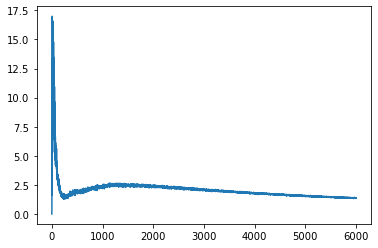

In [21]:
%matplotlib inline
fig,ax=plt.subplots()
ells = np.arange(mlmax+1)
ax.plot(ells**2*cl_ksz/2/np.pi)


Filter alms

In [7]:
z = np.zeros_like(alms)
alms_filtered = futils.isotropic_filter(
    (alms,z,z), tcls, lmin, lmax,
    ignore_te=True)[0]

In [8]:
print(np.any(np.isnan(alms_filtered)))

False


And run the estimator

In [9]:
K_recon = qfunc(alms_filtered,alms_filtered)

In [10]:
cl_KK = curvedsky.alm2cl(K_recon)

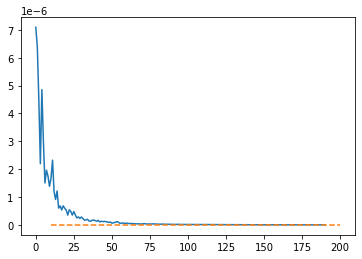

In [26]:
%matplotlib inline
L_min=10
L_max=200
ells_plot = np.arange(L_min,L_max+1)
fig,ax=plt.subplots()
ax.plot(cl_KK[L_min:L_max+1])
ax.plot(ells_plot, np.zeros_like(ells_plot),'--')
#ax.set_yscale('log')
#ax.set_xscale('log')

In [12]:
from copy import deepcopy
tcls_for_ts = deepcopy(tcls)
tcls_for_ts['TT'][:len(profile)] /= profile
ts_alms = futils.isotropic_filter(
    (alms,z,z), tcls_for_ts, lmin, lmax,
    ignore_te=True)[0]

In [27]:
k_map = hp.alm2map(ts_alms, nside=2048)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [28]:
print((k_map**2).mean())

859993.974729429


/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally re

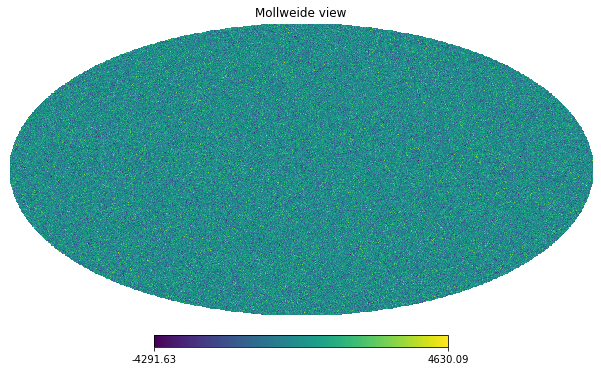

In [15]:
hp.mollview(k_map)